In [1]:
from context import lens
from lens.sis.inference import *
from lens.sie.plot import *

In [2]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import matplotlib as mp

In [3]:
mp.rcParams['figure.figsize'] = (12, 8)

In [4]:
# to drop warnings
import warnings
warnings.filterwarnings('ignore', category=Warning, append=True)

In [5]:
# read the Castle xmatch with DR2
url1 = 'http://vospace.esac.esa.int/vospace/sh/9da5bd4b841f4032ee3f94e2f357067a554434?dl=1'
d = Table.read(url1,format='votable').to_pandas()
d.qso_name = d.qso_name.str.decode('ascii')

centers = d.groupby(d.qso_name)['ra','dec'].mean()
centers['coord'] = SkyCoord(centers.ra,centers.dec,unit='degree')
centers = centers.reset_index()

print ("Total number of LQSO is {}".format(len(d)))

Total number of LQSO is 87


In [6]:
parameters = ['x','y','dx','dy','xe','ye','dxe','dye','g','ge']

def getLQSO(d,center,r=10):
    """
    get the objects in the pandas dataframe d at an angular distance less than r arcsecond
    
    Since Gaia does not provide g mag error, I use quick approximation using the flux error... 
    maybe one should rather adapt the SIS code to use flux instead of magnitude
    
    d :  pandas data frame
    center : astropy skycoordinate
    r : radius in arcsecond
    """
    s = d.copy()
    scale = u.deg.to(u.arcsecond)
    s['x'] = (d.ra - center.ra.deg)*scale*np.cos(d.dec*u.deg.to(u.rad))
    s['y'] = (d.dec-center.dec.deg)*scale
    s = s[np.power(s.x,2)+np.power(s.y,2)<r*r].copy()
    
    s['xe']=s.ra_error*u.mas.to(u.arcsec)*np.cos(d.dec*u.deg.to(u.rad))
    s['ye']=s.dec_error*u.mas.to(u.arcsec)
    
    s['dx']= s.pmra
    s['dy']= s.pmdec
    s['dxe']=s.pmra_error
    s['dye']=s.pmdec_error
    s['g'] = s.phot_g_mean_mag
    s['ge'] = s.phot_g_mean_mag/s.phot_g_mean_flux_over_error
    return s


def plotGaiaLense(dd,center,r=(-4,4),pm=True,title=""):
    """
    plot the position and the proper motion of the objects in the pandas dataframe d 
    at an angular distance of the center below 10 arcseconds
    d :  pandas data frame
    center : astropy skycoordinate
    r : plot x and y limits
    pm : to plot 
    """
    d = getLQSO(dd,center)
    if(title=="") :
        title = center
    plotGaiaLense2(d,r=r,pm=pm,title=title)
    
def plotGaiaLense2(d,r=(-4,4),pm=True,title=""):
    """
    plot the position and the proper motion of the objects in the pandas dataframe d 
    at an angular distance of the center below 10 arcseconds
    d :  pandas data frame
    center : astropy skycoordinate
    r : plot x and y limits
    pm : to plot 
    """
    x = d.x
    y = d.y
    plt.errorbar(x,y,xerr=d.xe*1e3, yerr=d.ye*1e3,fmt='.')
    plt.scatter(x,y,s=100*np.exp(20-d.g),
                c=d.astrometric_pseudo_colour,vmin=1.2,vmax=2,cmap=mp.cm.coolwarm_r)
    plt.colorbar(label="astrometric pseudo color $[\mu m^{-1}]$")
    if pm : 
        vx = d.dx
        vy = d.dy
        plt.quiver(x,y, vx, vy, angles='xy', scale_units='xy', scale=1)
        plt.errorbar(x+vx,y+vy,xerr=d.dxe, yerr=d.dye,fmt='o')
    plt.grid()
    plt.xlabel("x [\"]")
    plt.ylabel("y [\"]")
    plt.title(title)
    plt.xlim(r)
    plt.ylim(r)

note the clipboard should have been set with the correct data

In [7]:
center = centers[centers.qso_name=='SBS0909+523'].coord.values[0]

In [8]:
center

<SkyCoord (ICRS): (ra, dec) in deg
    (138.25440444, 52.99131744)>

In [9]:
np.cos(center.dec.rad)

0.6019360409410253

In [10]:
s = getLQSO(d,center)

In [11]:
s

,qso_name,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,x,y,xe,ye,dx,dy,dxe,dye,g,ge
25,SBS0909+523,1.635721e+18,b'Gaia DR2 1022663637669586176',1.022664e+18,1.533164e+09,2015.5,138.254177,0.155021,52.991387,0.213628,...,-0.493357,0.248677,0.000093,0.000214,-0.034002,-3.417185,0.291125,0.465921,16.416710,0.098849
26,SBS0909+523,1.635721e+18,b'Gaia DR2 1022663637670776192',1.022664e+18,1.373021e+09,2015.5,138.254632,0.075504,52.991248,0.135302,...,0.493359,-0.248677,0.000045,0.000135,-0.167852,0.770479,0.147239,0.249159,17.013699,0.101175


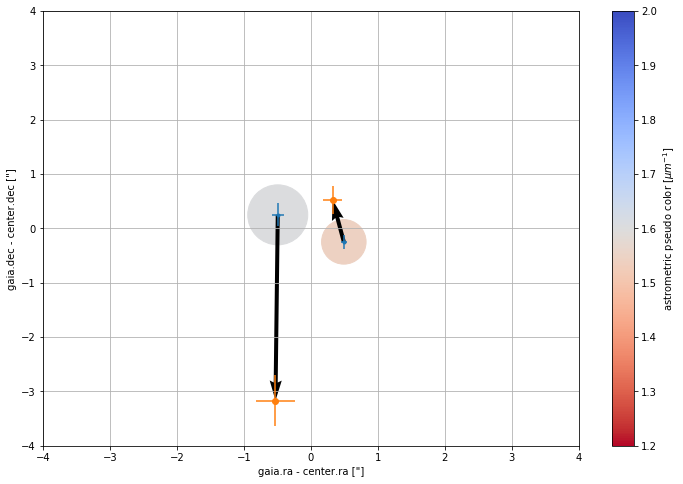

In [12]:
plotGaiaLense2(s)

In [13]:
s[parameters]

,x,y,dx,dy,xe,ye,dxe,dye,g,ge
25,-0.493357,0.248677,-0.034002,-3.417185,0.000093,0.000214,0.291125,0.465921,16.416710,0.098849
26,0.493359,-0.248677,-0.167852,0.770479,0.000045,0.000135,0.147239,0.249159,17.013699,0.101175


In [14]:
s.source_id

25    1.022664e+18
26    1.022664e+18
Name: source_id, dtype: float64

In [15]:
s['phot_g_mean_mag']

25    16.416710
26    17.013699
Name: phot_g_mean_mag, dtype: float32

In [16]:
s.phot_g_mean_mag-2.5*np.log(s.phot_g_mean_flux)

25   -4.932068
26   -2.960461
dtype: float64

In [17]:
s.phot_g_mean_mag/s.phot_g_mean_flux_over_error

25    0.098849
26    0.101175
dtype: float32

In [18]:
def plot_chains(sampler,warmup=400):
    fig, ax = plt.subplots(ndim,3, figsize=(12, 12))
    samples = sampler.chain[:, warmup:, :].reshape((-1, ndim))
    medians = {}
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i,0].vlines(warmup,np.min(sampler.chain[:, :, i].T),np.max(sampler.chain[:, :, i].T),'r')
        ax[i,1].hist(samples[:,i],bins=100,label=parameter[i]);
        ax[i,1].legend()
        ax[i,1].vlines(np.median(samples[:,i]),0,10000,lw=1,color='r',label="median")
        medians[parameter[i]]=(np.median(samples[:,i]))
        ax[i,2].hexbin(samples[:,i],samples[:,(i+1)%ndim])#,s=1,alpha=0.1);
    return medians

# SIS lens inference

In [19]:
parameter = "xS,yS,gS,bL,xL,yL".split(',')

In [20]:
data = s[['x','y','g','xe','ye','ge']].as_matrix()

In [21]:
data

array([[-4.93357353e-01,  2.48677000e-01,  1.64167099e+01,
         9.33123187e-05,  2.13627752e-04,  9.88487676e-02],
       [ 4.93358931e-01, -2.48677000e-01,  1.70136986e+01,
         4.54485964e-05,  1.35302460e-04,  1.01174615e-01]])

In [22]:
np.random.seed(0)
def init(N):
    """ to initialise each walkers initial value : sets parameter randomly """
    xS = norm.rvs(0,0.2,size=N)
    yS = norm.rvs(0,0.2,size=N)
    gS = gamma.rvs(10,5,size=N)
    xL = norm.rvs(0,0.2,size=N)
    yL = norm.rvs(0,0.2,size=N)
    bL = beta.rvs(2,3,size=N)
    return np.transpose(np.array([xS,yS,gS,bL,xL,yL]))

In [23]:
ndim = 6  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 1000  # number of MCMC steps

In [24]:
starting_guesses = init(nwalkers)

In [25]:
np.std([log_prior(guess) for guess in starting_guesses])

2.4913524849163284

In [26]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
%time x = sampler.run_mcmc(starting_guesses, nsteps)

CPU times: user 55.2 s, sys: 303 ms, total: 55.5 s
Wall time: 55.6 s


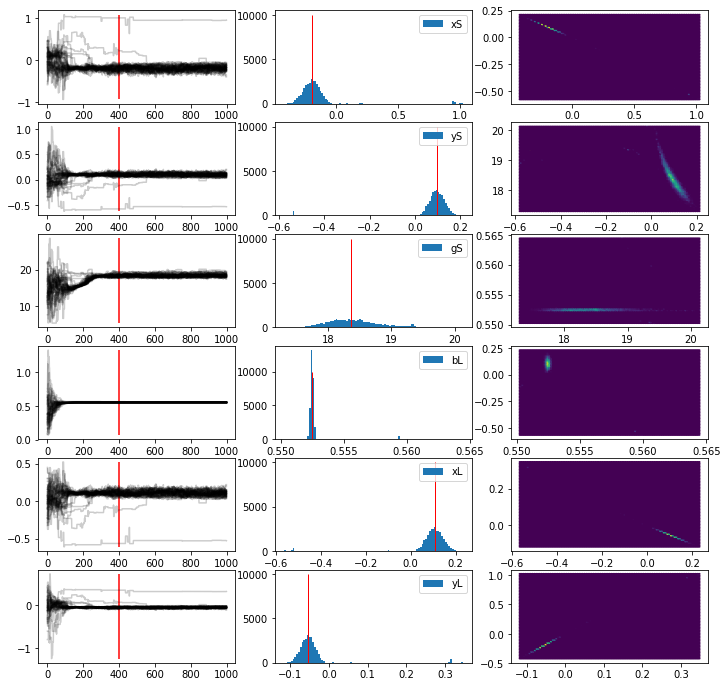

In [27]:
medians = plot_chains(sampler)

The lens inference distribution is at least bimodal. Indeed the magnitude difference between the 2 images is not large enough to clearly define the brightest image and the sampler is balancing between the 2. As a consequence the medians are values meaningless. 

In [28]:
medians

{'bL': 0.5524892676900681,
 'gS': 18.366628469214326,
 'xL': 0.10619731341420403,
 'xS': -0.1922306276940461,
 'yL': -0.05354130175520238,
 'yS': 0.09689586349449157}

In [29]:
def getModel(medians):
    return [medians['xS'],medians['yS'],medians['gS'],medians['bL'],medians['xL'],medians['yL']]

(-1, 1)

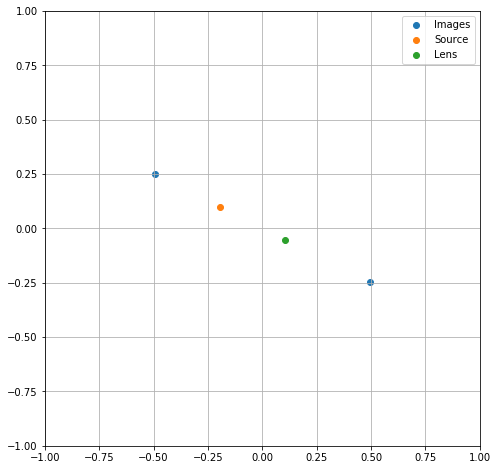

In [30]:
plt.subplot(aspect='equal')
images = np.array(getImages(getModel(medians)))
plt.scatter(images[:,0],images[:,1],label="Images")
plt.scatter(medians['xS'],medians['yS'],label="Source")
plt.scatter(medians['xL'],medians['yL'],label="Lens")
plt.legend()
plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)

In [31]:
getImages(getModel(medians))

[[-0.4933655619452877, 0.24867465219601864, 16.487407710352368],
 [0.4933494713291243, -0.24868940637788658, 16.962290333908918]]

In [32]:
data

array([[-4.93357353e-01,  2.48677000e-01,  1.64167099e+01,
         9.33123187e-05,  2.13627752e-04,  9.88487676e-02],
       [ 4.93358931e-01, -2.48677000e-01,  1.70136986e+01,
         4.54485964e-05,  1.35302460e-04,  1.01174615e-01]])

In [33]:
print((medians['xS']+medians['xL']),(medians['yS']+medians['yL']))

-0.08603331427984208 0.04335456173928919


It seems that there is a bug in SIE model, the image plot woth f=0.999 is different than the SIS one.

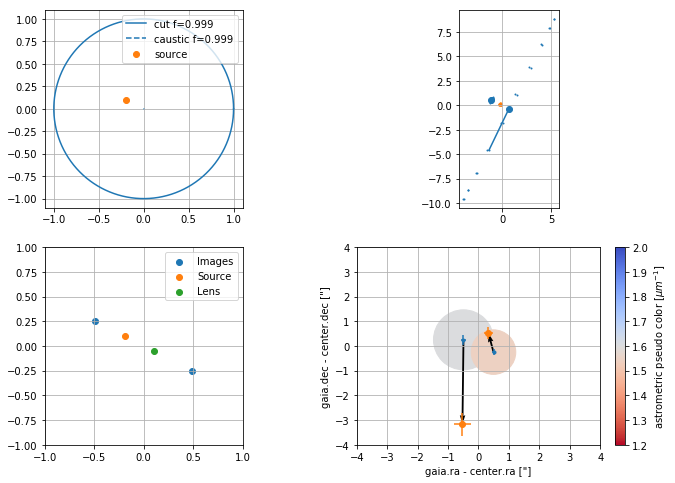

In [34]:
plotLensSourceImage(0.999,medians['xS'],medians['yS'])

plt.subplot(223,aspect='equal')
images = np.array(getImages(getModel(medians)))
plt.scatter(images[:,0],images[:,1],label="Images")
plt.scatter(medians['xS'],medians['yS'],label="Source")
plt.scatter(medians['xL'],medians['yL'],label="Lens")
plt.legend()
plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.subplot(224)
plotGaiaLense2(s)

In [35]:
np.random.seed(0)
def init2(N,medians):
    """ to initialise each walkers initial value : sets parameter randomly """
    xS = norm.rvs(medians['xS'],0.02,size=N)
    yS = norm.rvs(medians['yS'],0.02,size=N)
    gS = norm.rvs(medians['gS'],1,size=N)
    bL = norm.rvs(medians['bL'],0.1,size=N)
    xL = norm.rvs(medians['xL'],0.02,size=N)
    yL = norm.rvs(medians['yL'],0.01,size=N)
    
    return np.transpose(np.array([xS,yS,gS,bL,xL,yL]))

In [36]:
starting_guesses2 = init2(nwalkers,medians)

In [37]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
%time x = sampler.run_mcmc(starting_guesses2, nsteps)

CPU times: user 56.3 s, sys: 340 ms, total: 56.6 s
Wall time: 56.7 s


{'bL': 0.5524935266387514,
 'gS': 18.366780292708334,
 'xL': 0.10566882734931227,
 'xS': -0.1912334165235899,
 'yL': -0.053245200852341995,
 'yS': 0.0963898485584605}

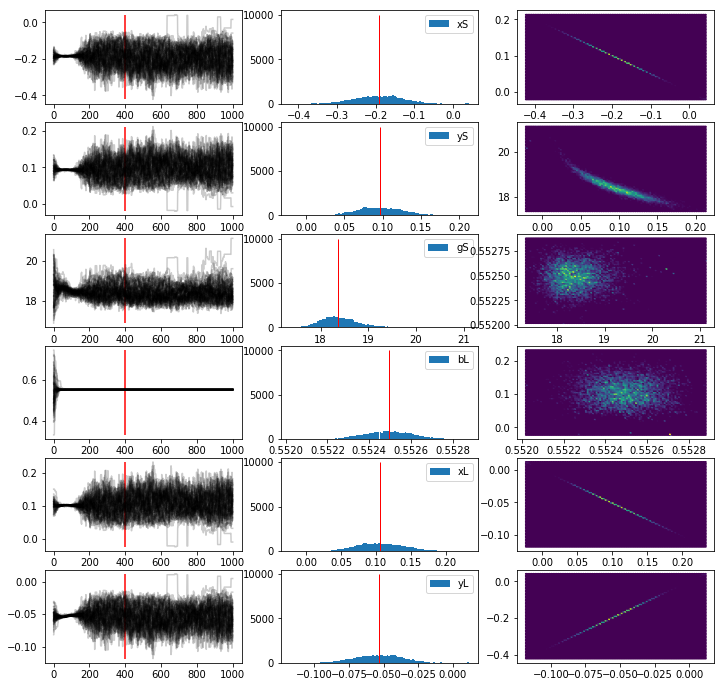

In [38]:
plot_chains(sampler)

# Proper motion inference

In [39]:
parameter = "xS,yS,dxS,dyS,gS,bL,xL,yL".split(',')

In [40]:
from lens.sis.inferencePM import *

In [41]:
data_pm = s[['x','y','dx','dy','g','xe','ye','dxe','dye','ge']].as_matrix()

In [42]:
data_pm

array([[-4.93357353e-01,  2.48677000e-01, -3.40017696e-02,
        -3.41718453e+00,  1.64167099e+01,  9.33123187e-05,
         2.13627752e-04,  2.91124546e-01,  4.65920820e-01,
         9.88487676e-02],
       [ 4.93358931e-01, -2.48677000e-01, -1.67852169e-01,
         7.70478985e-01,  1.70136986e+01,  4.54485964e-05,
         1.35302460e-04,  1.47239152e-01,  2.49159343e-01,
         1.01174615e-01]])

In [43]:
np.random.seed(0)
def initPM(N):
    """ to initialise each walkers initial value : sets parameter randomly """
    xS = norm.rvs(medians['xS'],0.02,size=N)
    yS = norm.rvs(medians['yS'],0.02,size=N)
    gS = norm.rvs(medians['gS'],1,size=N)
    bL = norm.rvs(medians['bL'],0.1,size=N)
    xL = norm.rvs(medians['xL'],0.02,size=N)
    yL = norm.rvs(medians['yL'],0.01,size=N)
    
    dxS = norm.rvs(0,0.1,size=N)
    dyS = norm.rvs(0,0.1,size=N)
    
    return np.transpose(np.array([xS,yS,dxS,dyS,gS,bL,xL,yL]))

In [44]:
ndim = 8  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 2000  # number of MCMC steps

In [45]:
starting_guesses_pm = initPM(nwalkers)

In [46]:
np.std([log_prior_pm(guess) for guess in starting_guesses_pm])

0.27235522443325716

In [47]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_pm, args=[data_pm])
%time x = sampler.run_mcmc(starting_guesses_pm, nsteps)

CPU times: user 2min 19s, sys: 802 ms, total: 2min 20s
Wall time: 2min 20s


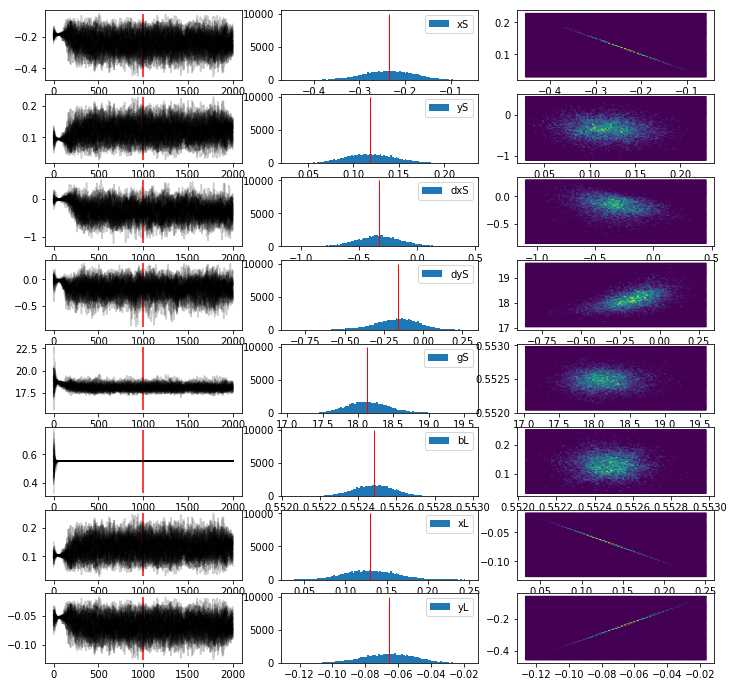

In [48]:
medians = plot_chains(sampler,warmup=1000)
plt.savefig("../data/images/PMI_%s.png"%s.qso_name.values[0])

In [49]:
medians

{'bL': 0.5524830407025165,
 'dxS': -0.32810109568700807,
 'dyS': -0.16177588434936246,
 'gS': 18.13289064463861,
 'xL': 0.13007910196794487,
 'xS': -0.2354335145209831,
 'yL': -0.06557448549207193,
 'yS': 0.118677486123585}

In [50]:
muS = np.array([medians['dxS'],medians['dyS']])*medians['bL']

In [51]:
print(muS)

[-0.18127029 -0.08937843]


In [52]:
np.linalg.norm(muS)

0.202107453093765

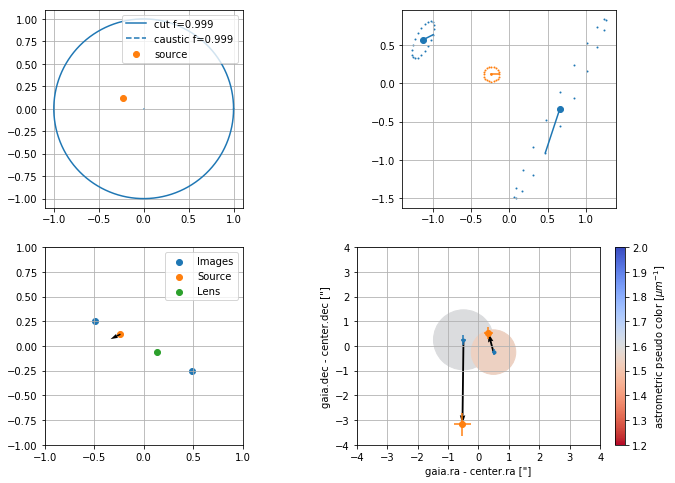

In [53]:
# WARNING there is a bug in the SIE implementation
plotLensSourceImage(0.999,medians['xS'],medians['yS'])

plt.subplot(223,aspect='equal')
images = np.array(getImages(getModel(medians)))
plt.scatter(images[:,0],images[:,1],label="Images")
plt.scatter(medians['xS'],medians['yS'],label="Source")
plt.scatter(medians['xL'],medians['yL'],label="Lens")
plt.quiver(medians['xS'],medians['yS'],medians['dxS'],medians['dyS'])
plt.legend()
plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.subplot(224)
plotGaiaLense2(s)